## Configure

In [1]:
source('../../gitProjectExtras/gitBasedProjects/R/sourceAllLibs.r')
sourceAllLibs('../../gitProjectExtras/gitBasedProjects/R/', trace = FALSE)
sourceAllLibs('../../rasterextrafuns/rasterPlotFunctions/R/', trace = FALSE)
sourceAllLibs('../../rasterextrafuns/rasterExtras/R/', trace = FALSE)

library(raster)
#library(rasterExtras)
library(fields)
sourceAllLibs("../libs/", trace = FALSE)
graphics.off()

matrix2list <- function(x, dim = 2) lapply(apply(x, dim, list), unlist) 


Loading required package: sp

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



### parameters

In [2]:
vars = c("fpc", "height", "gdd")

xlims = list(c(0, 1), c(0, 120), c(0, 1000))

transs  = list(logit, function(x, ...) logit(x/120, ...), log)
itranss = list(logistic, function(x, ...) 120 * logistic(x, ...), exp)

logisticit <- function(x, a) logistic(a*logit(x))

logisticitN <- function(x, ...)
    (logisticit(x, ...) - logisticit(0, ...))/(logisticit(1, ...) - logisticit(0, ...))

ptranss = list(function(x) logisticitN(x, 0.1) , function(x) (x/120)^0.2, function(x) 1-exp(-x*0.001))
pitranss = list(function(x) logisticitN(x, 10), function(x) (x^5)*120, function(x) -1000*log(1-x))


ForestCentres = list(CNRM   = list(c(-70, -0), c(-53, -08), c(-60, -10), c(-67, -14)),
                     ENS    = list(c(-72, -1), c(-54, -09), c(-61, -09), c(-66, -14)),
                     FGOALs = list(c(-70, -0), c(-55, -08), c(-60, -10), c(-67, -14)),
                     HADGEM = list(c(-70, -0), c(-52, -06), c(-67, -10)),
                     MIROC  = list(c(-75, -2), c(-51, -05), c(-61, -08), c(-66, -13)))
                
dir = '../outputs/'
                
speciesDist = "../outputs/bcObs-den/all.Rd"

In [88]:
findBioclimPnts <- function(dat, ForestCentre) {
    findPnt <- function(pnt)  
        dat[cellFromXY(dat, pnt)]
    
    sapply(ForestCentre, findPnt)    
}

In [89]:
testWhereInSphere <- function(bcranges, dats, transs) {
    shift = sapply(bcranges, mean)
    scale = sapply(bcranges, diff)/2
    
    siftScar <- function(sh, sc, dat, trans)
        ((trans(dat)) - sh)/sc
    sdats = mapply(siftScar, shift, scale, dats, transs)
    
    if (!is.raster(dats[[1]])) return(sdats)
    out = sqrt(sum(layer.apply(sdats, function(i) i^2)))<1
    out[out == 0] = NaN
    
    return(out)                              
}  

In [90]:
testNiche <- function(bcranges, ForestCentre, ...) {
    inSphere = testWhereInSphere(bcranges, ...)
    
    if (is.na(mean(inSphere[], na.rm = TRUE))) {
        print("broke")
        return(c(0))
    }
    pol = rasterToPolygons(inSphere, digits = 2, dissolve = TRUE)

     
    ps = lapply(pol@polygons , slot , "Polygons")[[1]]
    coords = lapply(ps, function(x) slot(x, "coords"))

    findPntInPol <- function(pnt){
        for (i in 1:length(coords)) {
            test = point.in.polygon(pnt[1], pnt[2], coords[[i]][,1], coords[[i]][,2])
            if (test) break
        }
        if (test) return(i) else return(NaN)
    }
    
    Cpols = sapply(ForestCentre, findPntInPol)
    if (all(is.na(Cpols))) out = 1 else if (any(is.na(Cpols)))  browser() else if (var(Cpols) > 0) out = 3 else out = 4
    return(c(out))
} 

In [91]:
randomBCrange <- function(i, continent_range, inRange = TRUE,  id = NULL) {    
    if (is.null(id))
        mu = sample(continent_range[,i], 1)
    else
        mu = continent_range[id, i]
    
    sd = runif(1, 0, 1)
    bcrange = mu + c(-1, 1) * logit(sd)
    bcrange = sort(bcrange)
    
    bcrange
}


selectPossibleNiche <- function(tcen) {
    dis = 2 
    id = sample(1:nrow(tcen), 1)
    p = sds = 0
    while( max(dis) > 1) {
        p = p + 1
        bcranges = lapply(1:3, randomBCrange, continent_range = tcen, id = id)
        dis = testWhereInSphere(bcranges, dats = matrix2list(tcen), list(blankFun))
        dis = apply(dis, 1, function(i) sqrt(sum(i^2)))                    
    }
    print(p)
    print(dis)
    
    return(bcranges)
}


In [92]:
grab_cache = TRUE
nboots = 300
testRandomNiche <- function(ntest, model, experiment, ForestCentre, tcen) {
    tfile = paste0("../temp/randomNicheTest--gdd-", model, '-', experiment, '-', ntest, ".Rd")
    print(tfile)
    
    #print(file.exists(tfile))
    if (file.exists(tfile) && grab_cache) 
        load(tfile)
    else {        
        bcranges = selectPossibleNiche(tcen)#lapply(1:3, randomBCrange, id = id)
        
        test = testNiche(bcranges, ForestCentre, dats, transs)
        save(bcranges, test, file = tfile)
    }
    print(test)
    return(list(bcranges, test))
}
runNicheBoots <- function(...)
    out = lapply(1:nboots, testRandomNiche, ...)


In [93]:
run4model <- function(model, ForestCentre) {
    experiments = list.files(paste0(dir, model, '/'))
    run4Exp <- function(experiment) {
        print(model)
        print(experiment)
        dats = suppressWarnings(lapply(vars, function(i) raster(paste0(dir, '/', model, '/', experiment, '/', i, '.nc'))))
        dats <<- dats
        
        centres = lapply(dats, findBioclimPnts, ForestCentre)
        
        tcen = mapply(function(F,i) F(i), transs, centres)
        
        out = runNicheBoots(model, experiment, ForestCentre = ForestCentre, tcen = tcen)
        return(list(out, centres))
        
    }
    
    lapply(experiments, run4Exp)
}

In [94]:
models = list.files(dir)
model = models[1]
ForestCentre = ForestCentres[[1]]


experiments = list.files(paste0(dir, model, '/'))
experiment = experiments[1]
outss = mapply(run4model, models, ForestCentres, SIMPLIFY = FALSE)

In [ ]:
addAxis <- function(i, side) {
    at = seq(0, 1, length.out = 11)
    
    labels = pitranss[[i]](at)
    if (labels[1] == 0 && tail(labels, 1) == 1) {
        test = labels>0.5
        labels[test] = 1-labels[test]
        labels = signif(labels, 1)
        labels[test] = 1 - labels[test]
    } else labels = signif(labels, 1)
    at = ptranss[[i]](labels)
    labels[labels < 9E-9] = 0
    test = labels>0.9 & labels < 1
    labels[!test] = signif(labels[!test], 1)
    
    axis(side, at = at, labels = labels)
}

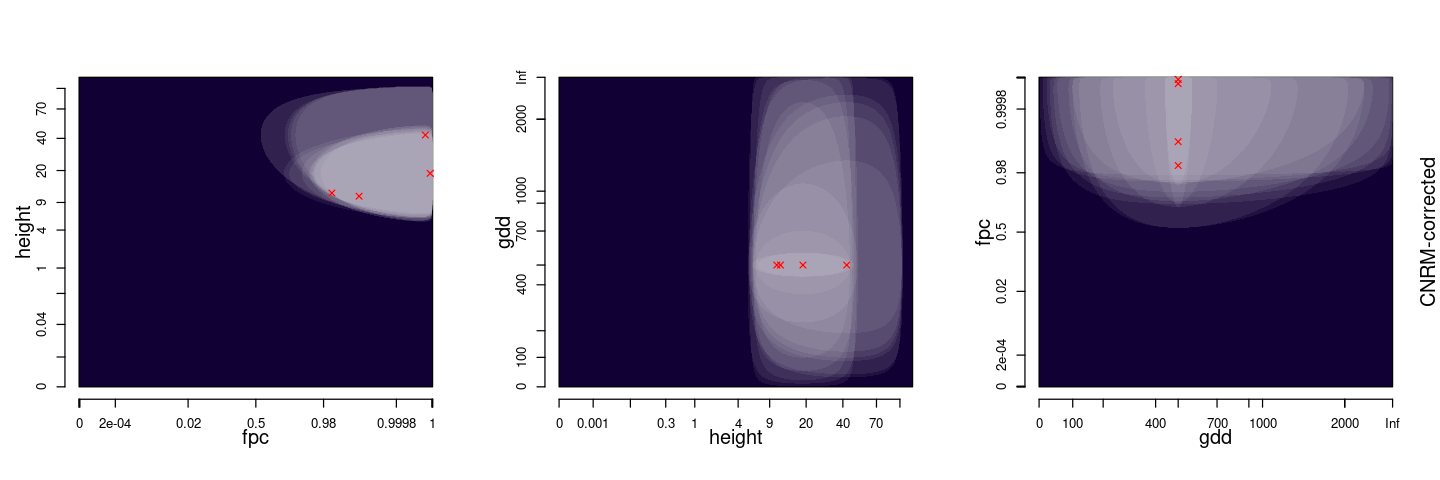

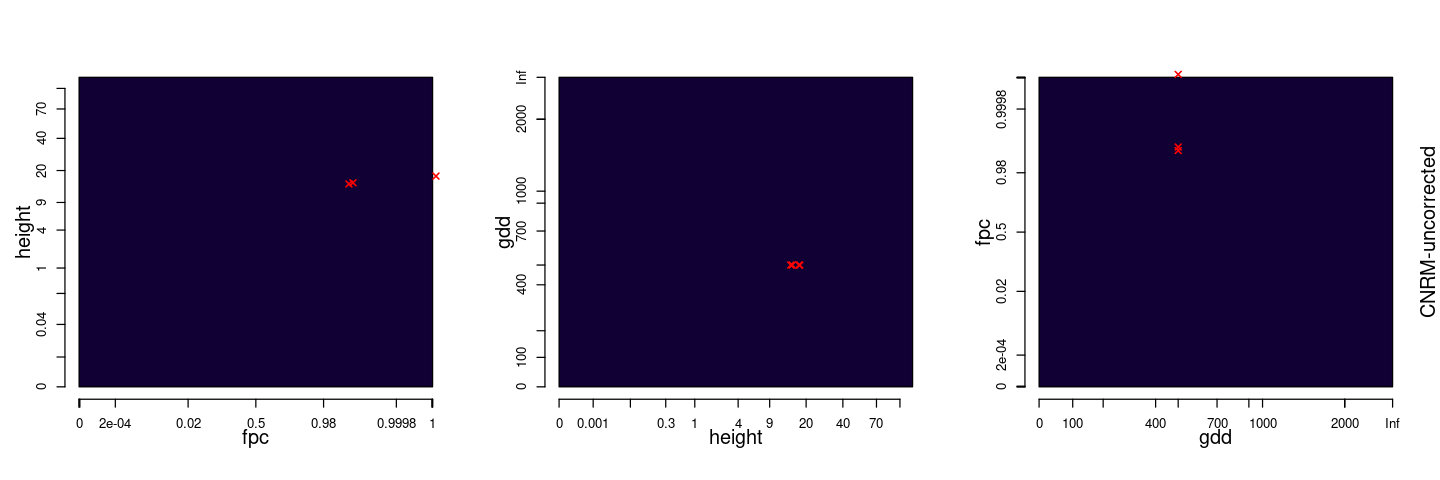

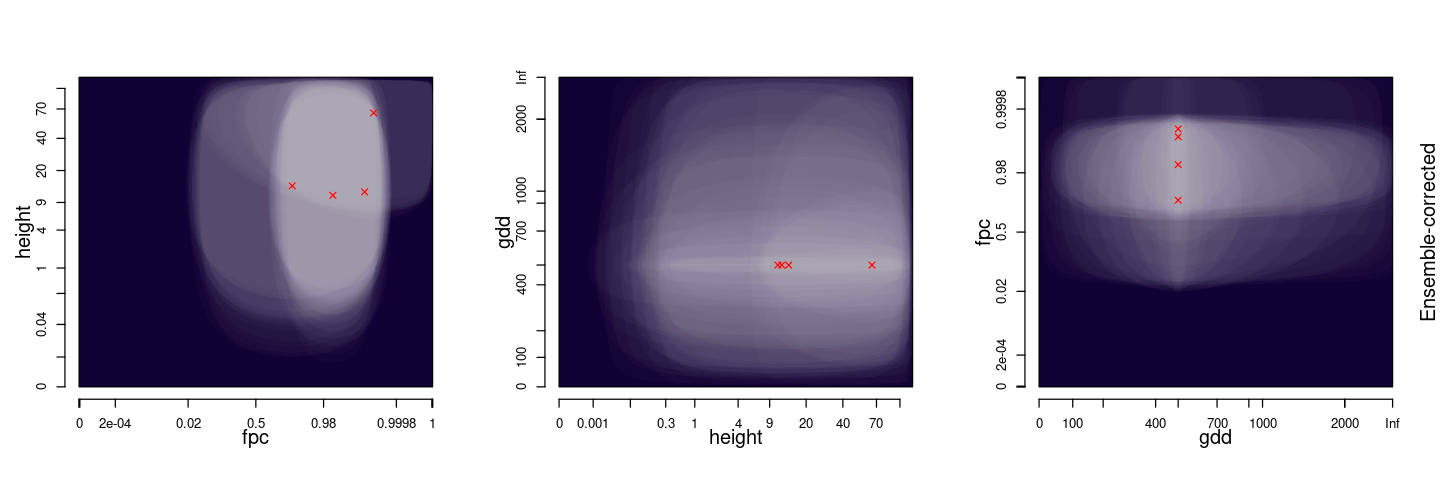

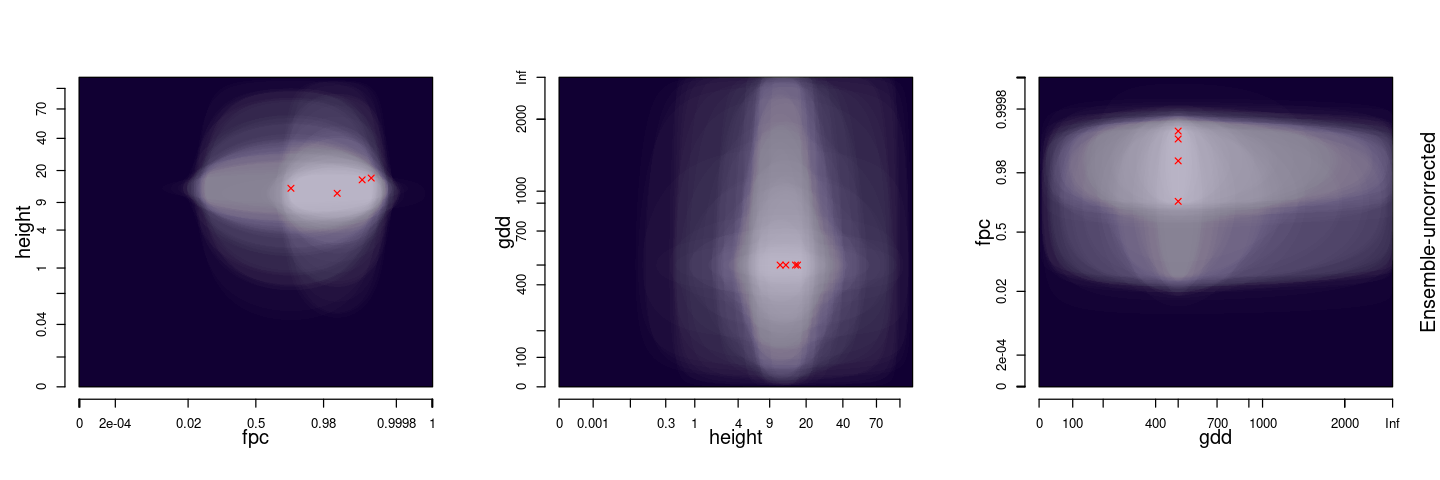

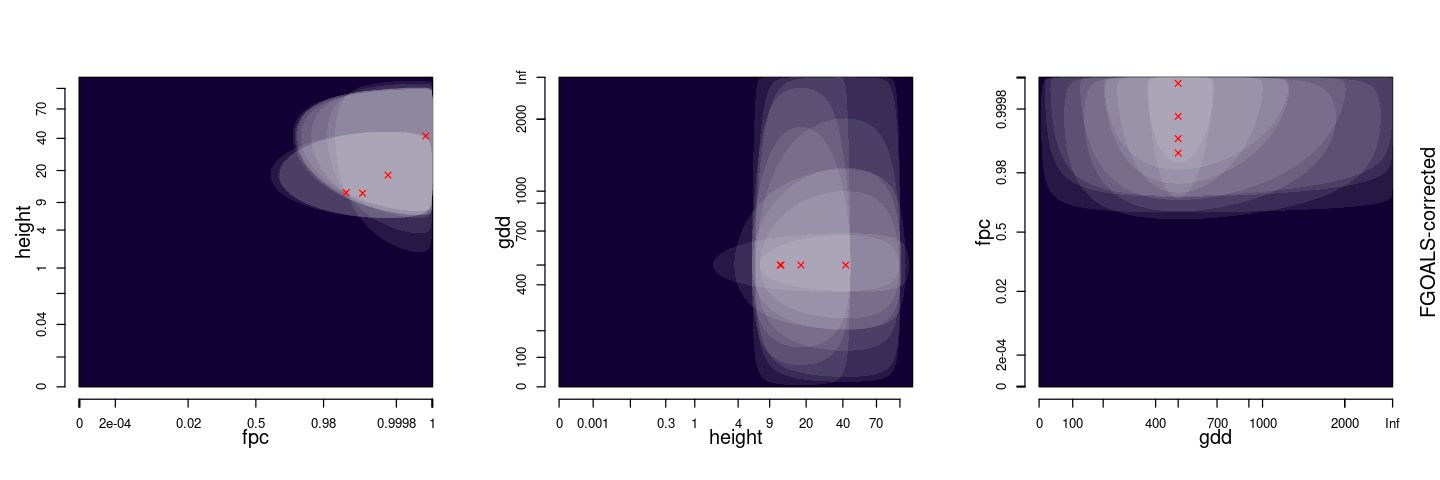

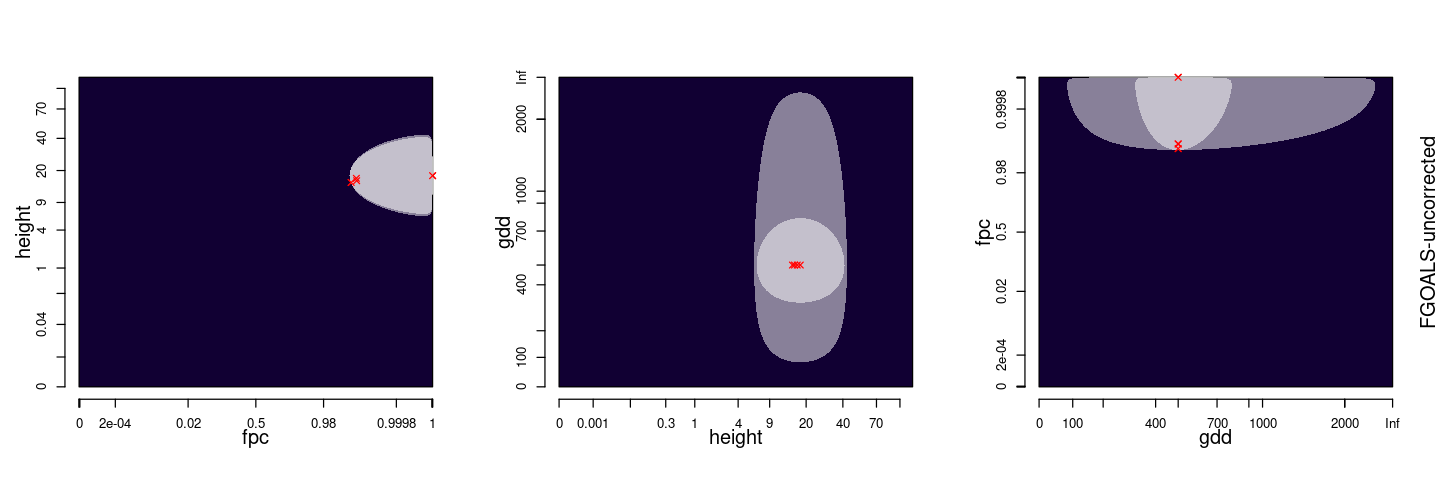

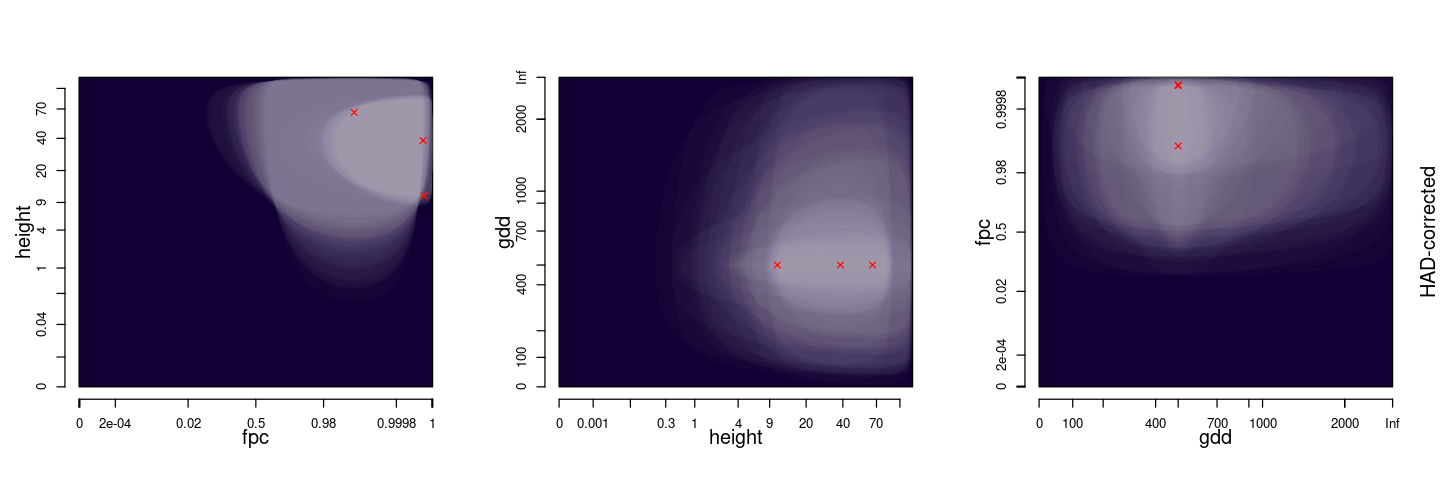

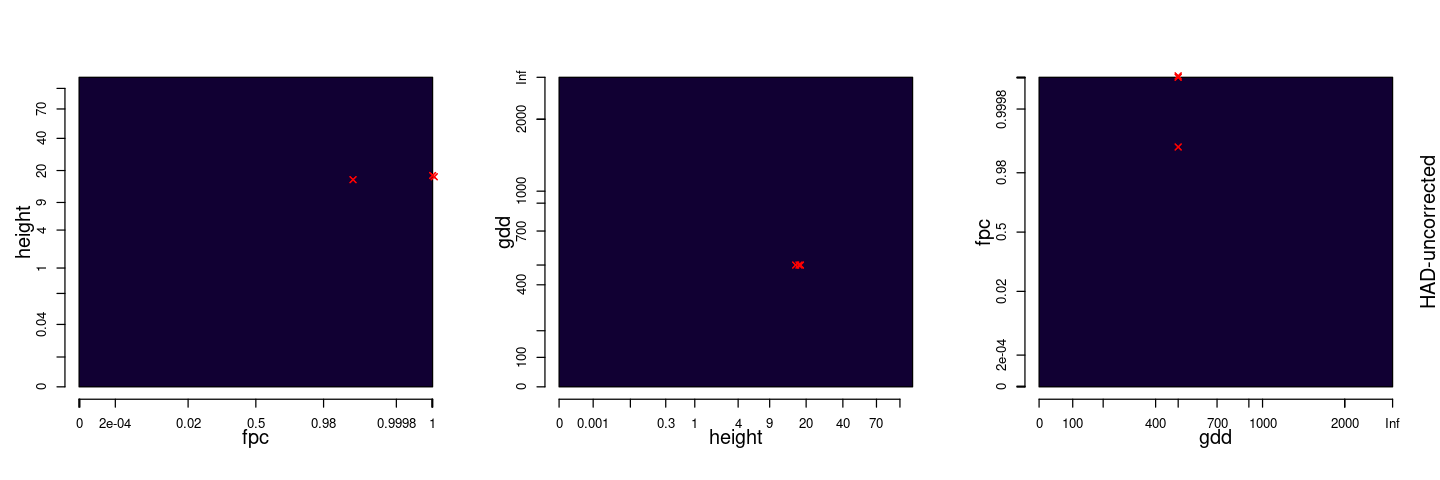

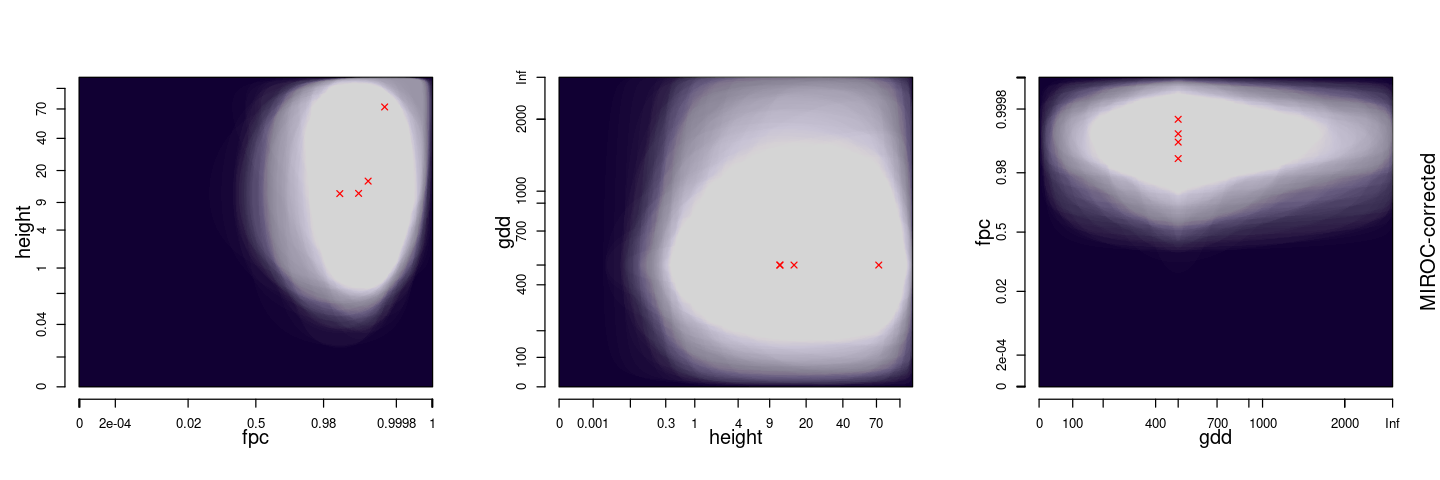

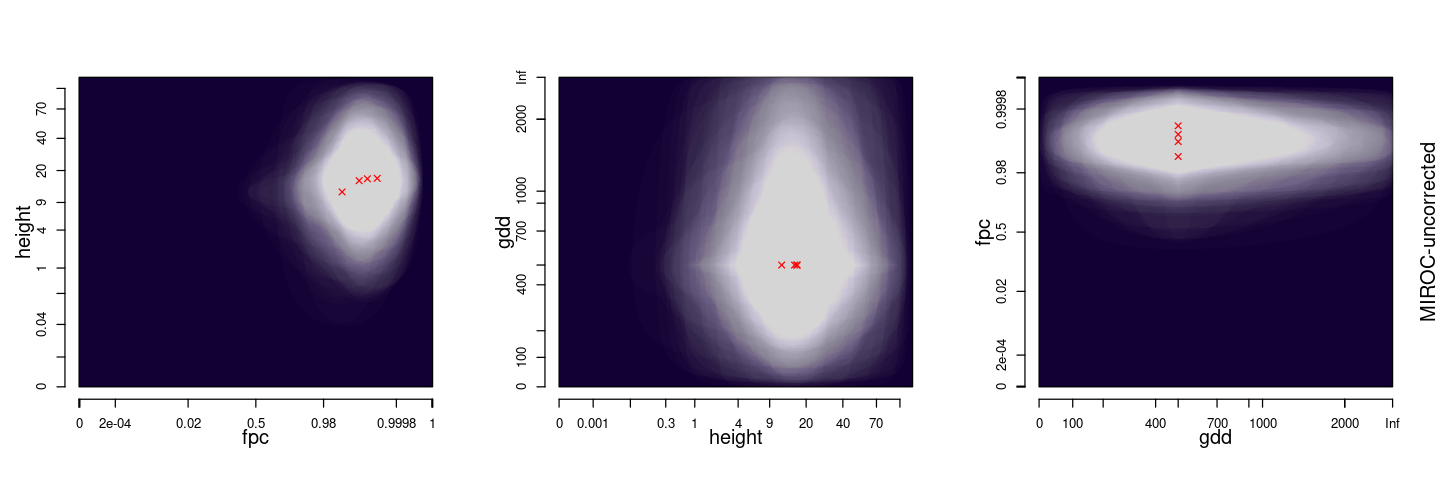

In [97]:
x = seq(-1, 1, 0.001)
y = sqrt(1-x^2)
x = c(x, rev(x)); y = c(y, -rev(y))


plotNichProb <- function(i, j, out) {
    
    centres = out[[2]]
    out = out[[1]]
    xc = ptranss[[i]](centres[[i]]); yc = ptranss[[j]](centres[[j]])
    
    plot(xc, yc, xlim = c(0,1), ylim = c(0,1), type = 'n', axes = FALSE, xlab = '', ylab = '')
    addAxis(i, 1)
    addAxis(j, 2)
    mtext(vars[i], side = 1, line = 2)
    mtext(vars[j], side = 2, line = 2)
    polygon(c(0, 1, 1, 0), c(0, 0, 1, 1), col = '#110033')
    
    addPoly <- function(fail, col, nc) {
        info = fail[[1]]

        shiftScale <- function(x, i){
            #x = logit(x)
            x = (x*diff(info[[i]])/2 + mean(info[[i]]))
            x = ptranss[[i]](itranss[[i]](x))
        }
        xt = shiftScale(x, i); yt = shiftScale(y, j)
        #browser()
        #xt = ptranss[[i]](xt); yt = ptranss[[i]](yt)
        polygon(xt, yt, col = make.transparent(col, min(0.99, 1-1/nc)), border = NA)
    }
    
    addPolys <- function(id, col) {
        con = out[sapply(out, function(i) i[[2]] == id)]                
        lapply(con, addPoly, col, length(con))
    }
    #addPolys(0, 'white')#'#110033')
    #addPolys(2, '#FF0000')
    points(xc, yc, pch = 4, col = 'red')
    addPolys(3, 'white') 
    points(xc, yc, pch = 4, col = 'red')
}
                         
plotNiches <- function(..., model, experiment)   {                     
    options(repr.plot.width=12, repr.plot.height=4)
    par(mfrow = c(1, 3))
    nn = plotNichProb(1, 2, ...)
    nn = plotNichProb(2, 3, ...)
    nn = plotNichProb(3, 1, ...)
    mtext(side = 4, paste0(model, '-', experiment), line = 1, xpd = TRUE)
}

plotModel <- function(outs, model)
    mapply(plotNiches, outs, experiment = experiments, MoreArgs = list(model = model))
    
                         
nn = mapply(plotModel, outss, models)
#outss[[1]][[1]][[1]]                       